### Data Visualization - Ideal vs Encountered

In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py


#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance
import geopandas as gpd
import utm
import datetime as dt

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from IPython.display import HTML


#### Load Data

In [140]:
set_number = 5

dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set0'+str(set_number)+'/'
windbag = 'wind0'+str(set_number)+'Run03.hdf'
westeast_load = 'ewdata0'+str(set_number)+'Run03.hdf'
northsouth_load= 'nsdata0'+str(set_number)+'Run03.hdf'
odor_load = 'Interpolated_'+str(set_number)+'.h5'
puffsize = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/puff_size.hdf')

In [15]:
#windbag
wind=pd.read_hdf(dir+windbag)
we=pd.read_hdf(dir+westeast_load)
ns=pd.read_hdf(dir+northsouth_load)

In [16]:
#odorbag
odor= pd.read_hdf(dir+odor_load)
time= odor.master_time-odor.master_time[0]
odor.insert(1,'sync_time',time) 

### Creating Dataframe for Puff Size

In [139]:
## creating puff dataframe
## going to copy to a new frame to keep this container separate as the for loop takes significant time to execute

# puff = pd.DataFrame(index=range(2987),columns=range(2987))
# puffsize=pd.DataFrame()

# for i in range(0, len(puff.columns)):
#     puff[i]=puff.index

# puff.columns = ['particle' + str(col) for col in puff.columns] #renaming for looping ease
# puffsize[0] = puff.iloc[:,0] #copying the first columns of data

# #shifting every column by the column-th number
# for i in range(1, len(puff.columns)):
#     puffsize[i]=puff['particle' + str(i)].shift(periods=i)

# puffsize=puffsize.fillna(0) #replacing NaN with zeroes
# puffsize.columns = ['particle' + str(col) for col in puffsize.columns] #renaming columns names optional
# puffsize= puffsize.astype(int)
# puffsize.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/puff_size.hdf', key='puffsize', mode='w')

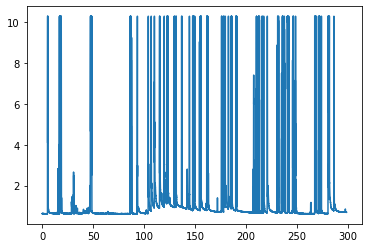

In [17]:
plt.plot(odor.sync_time, odor.odor)

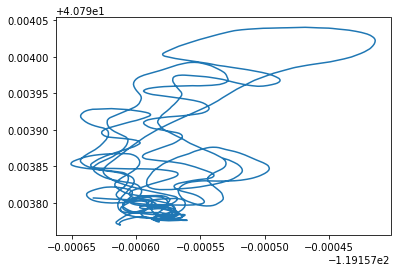

In [18]:
#plt.plot(we.particle0, ns.particle0)
plt.plot(odor.lon, odor.lat)

### Converting lat lon information to meters

In [19]:
from shapely.geometry import Point
odor['geometry'] = odor.apply(lambda row: Point(row.lon, row.lat), axis=1)

geodf = gpd.GeoDataFrame(odor)
geodf.crs= {'init': 'epsg:4326'}
# change the projection of geodf
geodf = geodf.to_crs("+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_def")

geodf["x"] = geodf.geometry.apply(lambda row:row.x)
geodf["y"] = geodf.geometry.apply(lambda row:row.y)

In [20]:
#source location to meters
source = (40.79376709443614, -119.15757512132207)
u =  utm.from_latlon(40.79376709443614, -119.15757512132207)

In [9]:
#adding sync_time from zero, optional

newtime= wind.sync_time-wind.sync_time.iloc[0]
wind.insert(1,'ntime',newtime) 

newtime=newtime.reset_index()
# newtime = newtime.drop(columns=['index'])

we.insert(0,'sync_time',newtime.sync_time)
ns.insert(0,'sync_time',newtime.sync_time)

In [10]:
xfromsrc= geodf.x-u[0]
geodf.insert(10,'xsrc',xfromsrc) 

yfromsrc = geodf.y-u[1]
geodf.insert(11,'ysrc', yfromsrc)

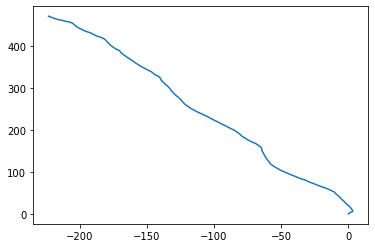

In [13]:
plt.plot(we.particle0, ns.particle0)

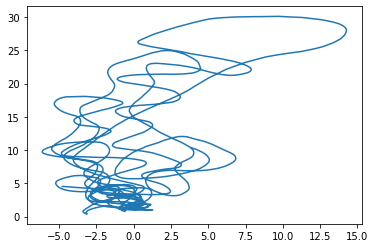

In [12]:
plt.plot(geodf.xsrc, geodf.ysrc)

#### Selecting a smaller slot of data

In [44]:
query = 'sync_time >= 100  and sync_time <=230'
dfo = odor.query(query)
dfwe = we.query(query)
dfns = ns.query(query)
dfwe = dfwe.reset_index()
dfns = dfns.reset_index()

In [45]:
query = 'odor >= 7'
df_t=geodf.query(query)
df_t=df_t.reset_index()

In [46]:
query_ = 'sync_time >=  and sync_time <=130'
geodfsub = geodf.query(query_)
geodfsub = geodfsub.reset_index()

In [15]:
# # # drop additional time stamps if necessary
# dfns = dfns.drop(columns=[ 'index1', 'sync_time'])
# dfwe = dfwe.drop(columns=['index', 'sync_time'])
# geodfsub = geodfsub.drop(columns = ['index', 'size'])

In [13]:
ns = ns.reset_index()
we = we.drop(columns=['sync_time'])
ns = ns.drop(columns=['index1','sync_time'])

#### Animation method using multiple plots (extremely slow)

In [15]:
dir = '../../../Research/Images/container01/'
N = 0
for i in range(len(geodf.xsrc)):
    fig = plt.figure()
    fig.suptitle('Odor Encounters')
    ax = plt.axes (xlim=(-8,15), ylim=(-2,30))
    ax.set_xlabel('Longitude (meters)')
    ax.set_ylabel('Latitude(meters)')
    if (i<=3000):
        ax.scatter(geodf.xsrc[:i],geodf.ysrc[:i], c=geodf.odor[:i], cmap='magma', s=geodf.index[:i]*0.001)
    else:
        ax.scatter(geodf.xsrc[N:i],geodf.ysrc[N:i], c=geodf.odor[N:i], cmap='magma', s=geodf.index[N:i]*0.001)
        N=N+1
        
    fig.savefig(dir + "plot" + str(i) + ".jpg")
    plt.close()

In [97]:
dir = '../../../Research/Images/container02/'
for i in range(len(we)):
    fig = plt.figure()
    fig.suptitle('Odor Encounters')
    ax = plt.axes (xlim=(-8,15), ylim=(-2,30))
    ax.set_xlabel('Longitude (meters)')
    ax.set_ylabel('Latitude(meters)')
    ax.scatter(we.loc[i], ns.loc[i],c ='b', cmap='magma', s=15)
    plt.plot(0,0, marker='x', markersize=15)
    fig.savefig(dir + "plot" + str(i) + ".jpg")
    plt.close()

#### Animation 01 - Wind Only

In [7]:
fig = plt.figure()
ax = plt.axes(xlim=(-22,2), ylim=(-15,30))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
plt.close()
line, = ax.scatter([],[], 'o', c =geodfsub.odor lw=2)

def init():
    line.set_data([],[])
    return line,

def get_data_x(i):
    return we.loc[i]

def get_data_y(i):
    return ns.loc[i]

def update(i):
    x = get_data_x(i)
    y = get_data_y(i)
    line.set_data(x,y)
    return line,

an = animation.FuncAnimation(fig,update,frames = pd.Index.intersection(we.index,ns.index),
                              interval = 5, blit=False)
#an.save('../../../Research/Images/Video/fast_flow.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
# plt.show()

#### 2D scatter plot for entire 300 seconds for ideal vs actual odor counters

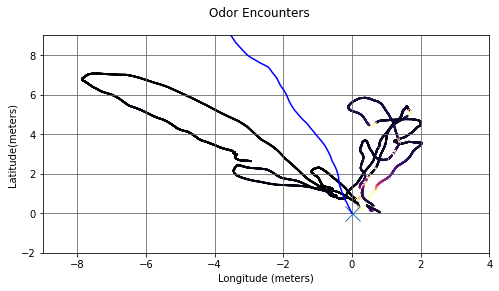

In [57]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor Encounters')
ax = plt.axes (xlim=(-9,4), ylim=(-2,9))
# Plot the data
ax.scatter(geodfsub.xsrc, geodfsub.ysrc, c=geodfsub.odor, cmap='magma', s= 0.8)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0, c='b')


#### 2D scatter plot for high odor concentration vs ideal wind particle

(-16.0, 3.0)

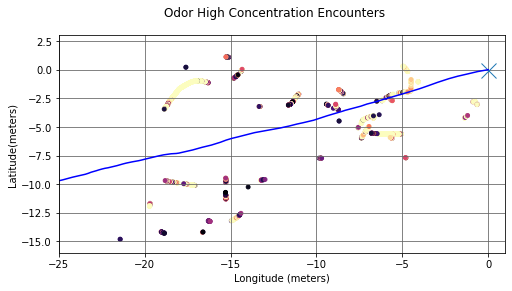

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor High Concentration Encounters')
ax = plt.axes (xlim=(-9,4), ylim=(-2,9))
# Plot the data
ax.scatter(df_t.xsrc, df_t.ysrc, c=df_t.odor, cmap='magma', s= 15)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0, markersize=20, c='b')


#### ANIMATION 02 - Ideal vs Encountered Odor

In [ ]:
## Setting figure

fig = plt.figure()
ax = plt.axes(xlim=(-9,4), ylim=(-2,9))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
plt.close()

wind, = ax.plot([],[], 'o', color ="b", lw = 2)
line, = ax.scatter([],[], c = geodfsub.odor, cmap='magma', s= 15)

def init():
    line.set_data([],[])  
    wind.set_data([],[])
    return wind,

def get_data_we_(i):
    return dfwe.loc[i]

def get_data_ns_(i):
    return dfns.loc[i]

def get_data_x_(i):
    return geodfsub.xsrc[i]

def get_data_y_(i):
    return geodfsub.ysrc[i]

def update(i):
#     wex = get_data_we_(i)
#     nsy = get_data_ns_(i)
#     wind.set_data(wex,nsy)
    x = get_data_x_(i)
    y = get_data_y_(i)
    line.set_data(x,y)
    
    return line,




In [19]:
# ani = animation.FuncAnimation(fig, update, init_func=init, frames = int(len(geodfsub.ysrc)/2), interval = 5, blit=False)
ani = animation.FuncAnimation(fig, update, init_func=init, frames = 500, interval = 5, blit=False)


#ani.save('../../../Research/Images/Video/test_ideal.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
#HTML(ani.to_html5_video())




#### Note: Number of rows for wind sensor for a certain time slot is much lesser than number of rows of the data collected (position data) >>>> GPS frequency is much higher